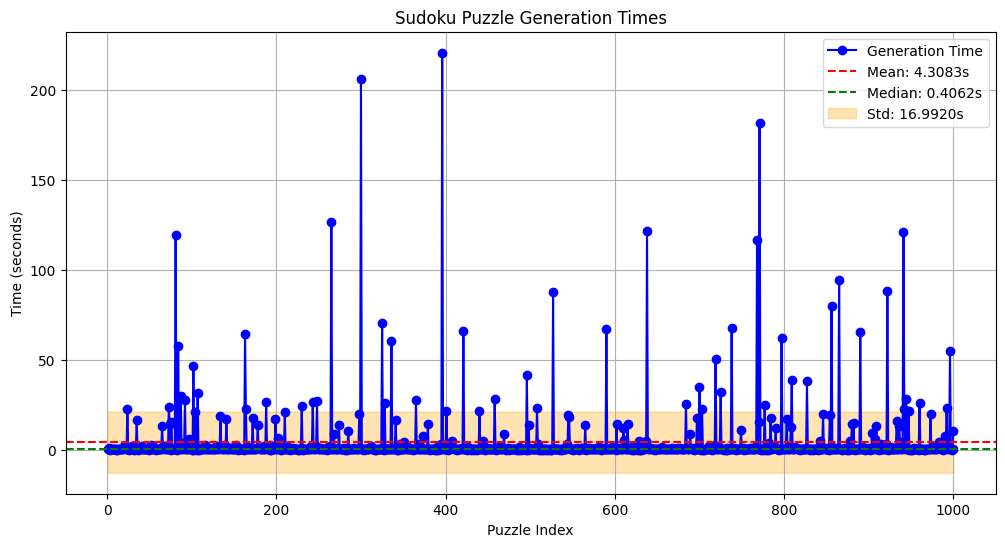

torch.Size([1000, 9, 9]) torch.Size([1000, 9, 9])


In [ ]:
import random
import torch
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Ensure matplotlib plots inline in the Jupyter notebook
%matplotlib inline

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid (for a 9x9 grid)
        self.side = self.base * self.base
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use CUDA if available

    # Create a full solution using a backtracking algorithm
    def solve(self, grid):
        find = self.find_empty(grid)
        if not find:
            return True  # Solved
        row, col = find

        for num in range(1, self.side + 1):
            if self.is_safe(grid, num, row, col):
                grid[row][col] = num

                if self.solve(grid):
                    return True

                grid[row][col] = 0

        return False

    # Check if it's safe to place a number in a given cell
    def is_safe(self, grid, num, row, col):
        if num in grid[row]:
            return False
        if num in [grid[i][col] for i in range(self.side)]:
            return False
        box_x = row // self.base * self.base
        box_y = col // self.base * self.base
        for i in range(self.base):
            for j in range(self.base):
                if grid[box_x + i][box_y + j] == num:
                    return False
        return True

    # Find the next empty cell
    def find_empty(self, grid):
        for i in range(self.side):
            for j in range(self.side):
                if grid[i][j] == 0:
                    return (i, j)
        return None

    # Generate a fully solved grid
    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8, device=self.device)  # Use CUDA tensor
        self.fill_diagonal_boxes(grid)
        self.solve(grid)
        return grid

    # Fill the diagonal 3x3 boxes with random numbers
    def fill_diagonal_boxes(self, grid):
        for i in range(0, self.side, self.base):
            self.fill_box(grid, i, i)

    # Fill a 3x3 box
    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    # Remove numbers to create the puzzle
    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()  # Create a copy of the grid
        count = num_holes
        while count > 0:
            row = random.randint(0, self.side - 1)
            col = random.randint(0, self.side - 1)
            if puzzle[row][col] != 0:
                puzzle[row][col] = 0
                count -= 1
        return puzzle

    # Generate multiple puzzles and solutions as int8 tensors
    def generate_puzzles(self, num_puzzles=5):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8, device=self.device)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8, device=self.device)

        generation_times = []  # List to store generation times for each puzzle

        for idx in range(num_puzzles):
            start_time = time.time()  # Record the start time for puzzle generation

            solution = self.generate_solution_grid()
            num_holes = random.randint(12, 40)  # Random number of holes between 12 and 40
            puzzle = self.remove_numbers(solution, num_holes)
            puzzles[idx] = puzzle
            solutions[idx] = solution

            end_time = time.time()  # Record the end time for puzzle generation
            elapsed_time = end_time - start_time  # Calculate elapsed time
            generation_times.append(elapsed_time)  # Append time to list

            # Convert to tensor for calculations
            generation_times_tensor = torch.tensor(generation_times, device=self.device, dtype=torch.float)

            # Calculate mean, standard deviation, and median using PyTorch
            mean_time = generation_times_tensor.mean().item()
            std_time = generation_times_tensor.std().item()
            median_time = generation_times_tensor.median().item()

            # Print the time taken for each puzzle and current mean, std, and median
            print(f"Puzzle {idx + 1} generated in {elapsed_time:.4f} seconds. "
                  f"Mean Time: {mean_time:.4f}s, Std: {std_time:.4f}s, Median: {median_time:.4f}s")

            # Live updating of the plot
            fig, ax = plt.subplots(figsize=(12, 6))  # Create a figure and axis object
            ax.plot(range(1, len(generation_times) + 1), generation_times, marker='o', color='b', label='Generation Time')
            ax.axhline(mean_time, color='r', linestyle='--', label=f'Mean: {mean_time:.4f}s')
            ax.axhline(median_time, color='g', linestyle='--', label=f'Median: {median_time:.4f}s')
            ax.fill_between(range(1, len(generation_times) + 1),
                             mean_time - std_time,
                             mean_time + std_time,
                             color='orange', alpha=0.3, label=f'Std: {std_time:.4f}s')

            ax.set_title('Sudoku Puzzle Generation Times')
            ax.set_xlabel('Puzzle Index')
            ax.set_ylabel('Time (seconds)')
            ax.legend()
            ax.grid(True)
            clear_output(wait=True)  # Clear previous plot
            display(fig)  # Display the current plot
            plt.close(fig)  # Close the figure to avoid retaining old plots

        return puzzles, solutions

# Example usage
sudoku = SudokuGenerator()
puzzles, solutions = sudoku.generate_puzzles(num_puzzles=1000)

print(puzzles.size(), solutions.size())


## Without any  parallel operations 1000 sudoku puzzles took 1 hour to generate whitch is a joke

also a quick check for the duplicats , but for such a small quantity it should not be a problem YET

In [ ]:


# Reshape the tensor to 1000 x 81 (9*9=81)
reshaped_tensor = solutions.view(solutions.size(0), -1)

# Get unique rows and their indices
unique_rows, indices = torch.unique(reshaped_tensor, dim=0, return_inverse=True)

# Check for duplicates
duplicates = torch.bincount(indices) > 1

# Get the indices of duplicate rows
duplicate_indices = duplicates.nonzero(as_tuple=True)[0]

# Print results
print("Duplicate rows found at indices:", duplicate_indices)


Duplicate rows found at indices: tensor([], device='cuda:0', dtype=torch.int64)


Now , here comes the simillar code but with parallel generation

In [ ]:
import random
import torch
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import time

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid
        self.side = self.base * self.base
        self.times = []

    def solve(self, grid, row, col, num):
        for n in range(1, self.side + 1):
            if self.is_safe(grid, n, row, col):
                grid[row][col] = n
                if self.solve(grid, *self.find_empty(grid)):
                    return True
                grid[row][col] = 0
        return False

    def is_safe(self, grid, num, row, col):
        return (num not in grid[row] and
                num not in grid[:, col] and
                num not in grid[row // self.base * self.base: (row // self.base + 1) * self.base,
                               col // self.base * self.base: (col // self.base + 1) * self.base])

    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8)
        self.fill_diagonal_boxes(grid)
        self.solve(grid, 0, 0, None)
        return grid

    def fill_diagonal_boxes(self, grid):
        for i in range(0, self.side, self.base):
            self.fill_box(grid, i, i)

    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()
        cells = list(range(self.side * self.side))
        random.shuffle(cells)

        for index in cells[:num_holes]:
            row, col = divmod(index, self.side)
            puzzle[row][col] = 0

        return puzzle

    def generate_single_puzzle(self):
        start_time = time.time()
        solution = self.generate_solution_grid()
        num_holes = random.randint(12, 40)
        puzzle = self.remove_numbers(solution, num_holes)
        elapsed_time = time.time() - start_time
        self.times.append(elapsed_time)
        return puzzle, solution

    def generate_puzzles(self, num_puzzles=5):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)

        with ThreadPoolExecutor(max_workers=20) as executor:
            futures = [executor.submit(self.generate_single_puzzle) for _ in range(num_puzzles)]
            for idx, future in enumerate(futures):
                try:
                    puzzle, solution = future.result(timeout=6)
                    puzzles[idx] = puzzle
                    solutions[idx] = solution
                except TimeoutError:
                    print(f"Puzzle {idx + 1} generation timed out.")

        return puzzles, solutions

# Example usage
if __name__ == "__main__":
    sudoku = SudokuGenerator()
    puzzles1, solutions1 = sudoku.generate_puzzles(num_puzzles=100000)
    print(puzzles1.size(), solutions1.size())


torch.Size([100000, 9, 9]) torch.Size([100000, 9, 9])


In [1]:
import random
import torch
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import time
from tqdm import tqdm  # Import tqdm for the loading bar

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid
        self.side = self.base * self.base
        self.times = []

    def solve(self, grid, row, col, num):
        for n in range(1, self.side + 1):
            if self.is_safe(grid, n, row, col):
                grid[row][col] = n
                if self.solve(grid, *self.find_empty(grid)):
                    return True
                grid[row][col] = 0
        return False

    def is_safe(self, grid, num, row, col):
        return (num not in grid[row] and
                num not in grid[:, col] and
                num not in grid[row // self.base * self.base: (row // self.base + 1) * self.base,
                               col // self.base * self.base: (col // self.base + 1) * self.base])

    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8)
        self.fill_diagonal_boxes(grid)
        self.solve(grid, 0, 0, None)
        return grid

    def fill_diagonal_boxes(self, grid):
        for i in range(0, self.side, self.base):
            self.fill_box(grid, i, i)

    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()
        cells = list(range(self.side * self.side))
        random.shuffle(cells)

        for index in cells[:num_holes]:
            row, col = divmod(index, self.side)
            puzzle[row][col] = 0

        return puzzle

    def generate_single_puzzle(self):
        start_time = time.time()
        solution = self.generate_solution_grid()
        num_holes = random.randint(12, 40)
        puzzle = self.remove_numbers(solution, num_holes)
        elapsed_time = time.time() - start_time
        self.times.append(elapsed_time)
        return puzzle, solution

    def generate_puzzles(self, num_puzzles=5):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)

        with ThreadPoolExecutor(max_workers=20) as executor:
            futures = [executor.submit(self.generate_single_puzzle) for _ in range(num_puzzles)]
            for idx, future in tqdm(enumerate(futures), total=num_puzzles, desc="Generating Puzzles"):
                try:
                    puzzle, solution = future.result(timeout=6)
                    puzzles[idx] = puzzle
                    solutions[idx] = solution
                except TimeoutError:
                    print(f"Puzzle {idx + 1} generation timed out.")

        return puzzles, solutions

# Example usage
if __name__ == "__main__":
    sudoku = SudokuGenerator()
    puzzles1, solutions1 = sudoku.generate_puzzles(num_puzzles=100000)
    print(puzzles1.size(), solutions1.size())


Generating Puzzles: 100%|██████████| 100000/100000 [03:07<00:00, 532.06it/s]


torch.Size([100000, 9, 9]) torch.Size([100000, 9, 9])


In [3]:
# Reshape the tensor to 1000 x 81 (9*9=81)
reshaped_tensor = solutions1.view(solutions1.size(0), -1)

# Get unique rows and their indices
unique_rows, indices = torch.unique(reshaped_tensor, dim=0, return_inverse=True)

# Check for duplicates
duplicates = torch.bincount(indices) > 1

# Get the indices of duplicate rows
duplicate_indices = duplicates.nonzero(as_tuple=True)[0]

# Print results
print("Duplicate rows found at indices:", duplicate_indices)

Duplicate rows found at indices: tensor([], dtype=torch.int64)


### here is the same code but with some visualizations for better understanding

Generating Puzzles: 100%|██████████| 500/500 [00:00<00:00, 549.08it/s]


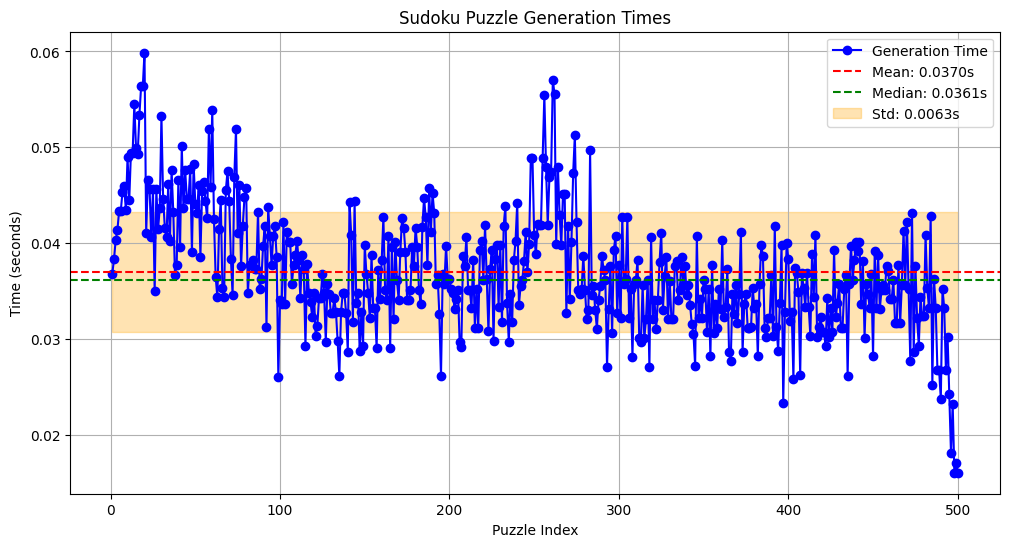

torch.Size([500, 9, 9]) torch.Size([500, 9, 9])


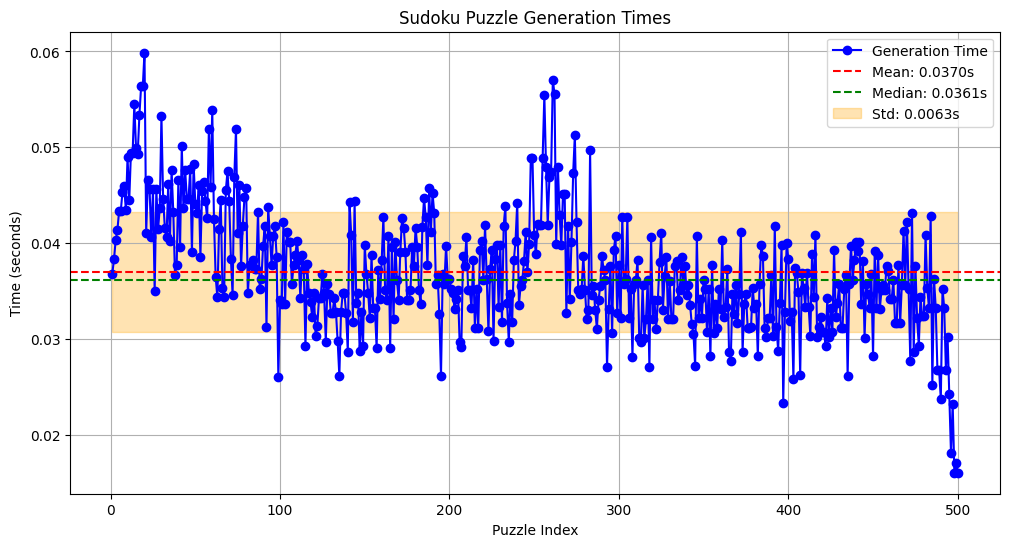

In [2]:
import random
import torch
import time
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from tqdm import tqdm  # Import tqdm for the loading bar
import matplotlib.pyplot as plt  # Import for plotting
from IPython.display import display  # For displaying the plot in Jupyter

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid
        self.side = self.base * self.base
        self.times = []  # List to store generation times

    def solve(self, grid, row, col, num):
        for n in range(1, self.side + 1):
            if self.is_safe(grid, n, row, col):
                grid[row][col] = n
                if self.solve(grid, *self.find_empty(grid)):
                    return True
                grid[row][col] = 0
        return False

    def is_safe(self, grid, num, row, col):
        return (num not in grid[row] and
                num not in grid[:, col] and
                num not in grid[row // self.base * self.base: (row // self.base + 1) * self.base,
                               col // self.base * self.base: (col // self.base + 1) * self.base])

    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8)
        self.fill_diagonal_boxes(grid)
        self.solve(grid, 0, 0, None)
        return grid

    def fill_diagonal_boxes(self, grid):
        for i in range(0, self.side, self.base):
            self.fill_box(grid, i, i)

    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()
        cells = list(range(self.side * self.side))
        random.shuffle(cells)

        for index in cells[:num_holes]:
            row, col = divmod(index, self.side)
            puzzle[row][col] = 0

        return puzzle

    def generate_single_puzzle(self):
        start_time = time.time()
        solution = self.generate_solution_grid()
        num_holes = random.randint(12, 40)
        puzzle = self.remove_numbers(solution, num_holes)
        elapsed_time = time.time() - start_time
        self.times.append(elapsed_time)
        return puzzle, solution

    def generate_puzzles(self, num_puzzles=5):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)

        with ThreadPoolExecutor(max_workers=20) as executor:
            futures = [executor.submit(self.generate_single_puzzle) for _ in range(num_puzzles)]
            for idx, future in tqdm(enumerate(futures), total=num_puzzles, desc="Generating Puzzles"):
                try:
                    puzzle, solution = future.result(timeout=6)
                    puzzles[idx] = puzzle
                    solutions[idx] = solution
                except TimeoutError:
                    print(f"Puzzle {idx + 1} generation timed out.")

        # Calculate statistics after all puzzles are generated
        times_tensor = torch.tensor(self.times, dtype=torch.float32)
        mean_time = torch.mean(times_tensor).item()
        std_time = torch.std(times_tensor).item()
        median_time = torch.median(times_tensor).item()

        # Create a final plot after generating all puzzles
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(range(1, len(self.times) + 1), self.times, marker='o', color='b', label='Generation Time')
        ax.axhline(mean_time, color='r', linestyle='--', label=f'Mean: {mean_time:.4f}s')
        ax.axhline(median_time, color='g', linestyle='--', label=f'Median: {median_time:.4f}s')
        ax.fill_between(range(1, len(self.times) + 1),
                         mean_time - std_time,
                         mean_time + std_time,
                         color='orange', alpha=0.3, label=f'Std: {std_time:.4f}s')

        ax.set_title('Sudoku Puzzle Generation Times')
        ax.set_xlabel('Puzzle Index')
        ax.set_ylabel('Time (seconds)')
        ax.legend()
        ax.grid(True)
        display(fig)  # Display the final plot

        return puzzles, solutions

# Example usage
if __name__ == "__main__":
    sudoku = SudokuGenerator()
    puzzles1, solutions1 = sudoku.generate_puzzles(num_puzzles=500)
    print(puzzles1.size(), solutions1.size())


Generating Puzzles: 100%|██████████| 1000000/1000000 [28:48<00:00, 578.57it/s]


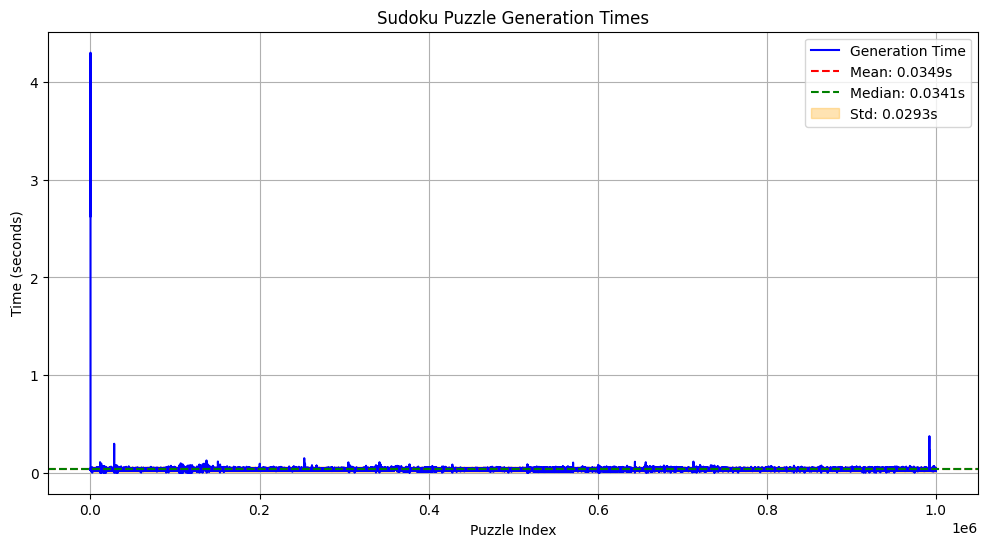

torch.Size([1000000, 9, 9]) torch.Size([1000000, 9, 9])


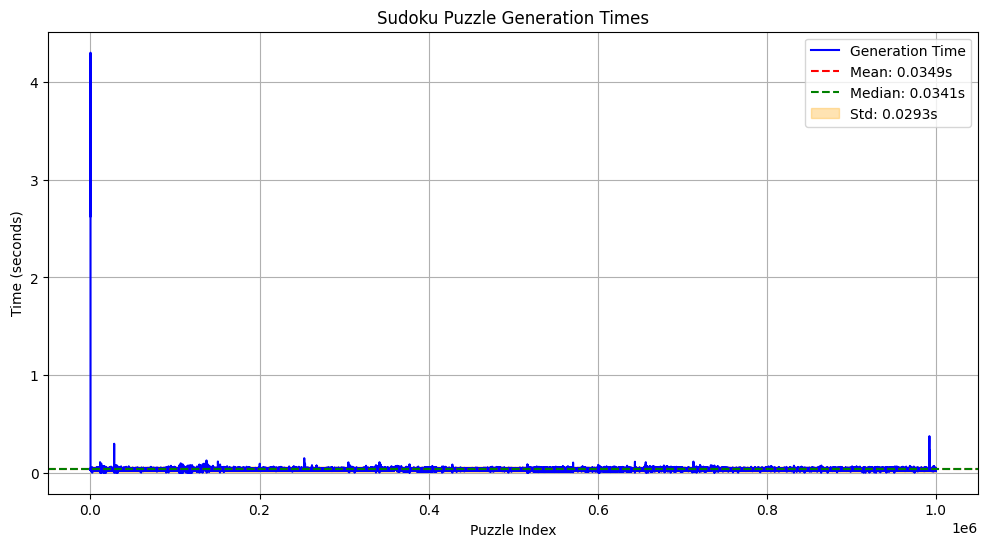

In [7]:
import random
import torch
import time
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from tqdm import tqdm  # Import tqdm for the loading bar
import matplotlib.pyplot as plt  # Import for plotting
from IPython.display import display  # For displaying the plot in Jupyter

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid
        self.side = self.base * self.base
        self.times = []  # List to store generation times

    def solve(self, grid, row, col, num):
        for n in range(1, self.side + 1):
            if self.is_safe(grid, n, row, col):
                grid[row][col] = n
                if self.solve(grid, *self.find_empty(grid)):
                    return True
                grid[row][col] = 0
        return False

    def is_safe(self, grid, num, row, col):
        return (num not in grid[row] and
                num not in grid[:, col] and
                num not in grid[row // self.base * self.base: (row // self.base + 1) * self.base,
                               col // self.base * self.base: (col // self.base + 1) * self.base])

    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8)
        self.fill_diagonal_boxes(grid)
        self.solve(grid, 0, 0, None)
        return grid

    def fill_diagonal_boxes(self, grid):
        for i in range(0, self.side, self.base):
            self.fill_box(grid, i, i)

    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()
        cells = list(range(self.side * self.side))
        random.shuffle(cells)

        for index in cells[:num_holes]:
            row, col = divmod(index, self.side)
            puzzle[row][col] = 0

        return puzzle

    def generate_single_puzzle(self):
        start_time = time.time()
        solution = self.generate_solution_grid()
        num_holes = random.randint(12, 40)
        puzzle = self.remove_numbers(solution, num_holes)
        elapsed_time = time.time() - start_time
        self.times.append(elapsed_time)
        return puzzle, solution

    def generate_puzzles(self, num_puzzles=5):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)

        with ThreadPoolExecutor(max_workers=20) as executor:
            futures = [executor.submit(self.generate_single_puzzle) for _ in range(num_puzzles)]
            for idx, future in tqdm(enumerate(futures), total=num_puzzles, desc="Generating Puzzles"):
                try:
                    puzzle, solution = future.result(timeout=6)
                    puzzles[idx] = puzzle
                    solutions[idx] = solution
                except TimeoutError:
                    print(f"Puzzle {idx + 1} generation timed out.")

        # Calculate statistics after all puzzles are generated
        times_tensor = torch.tensor(self.times, dtype=torch.float32)
        mean_time = torch.mean(times_tensor).item()
        std_time = torch.std(times_tensor).item()
        median_time = torch.median(times_tensor).item()

        # Create a final plot after generating all puzzles
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(range(1, len(self.times) + 1), self.times, color='b', label='Generation Time')  # No markers
        ax.axhline(mean_time, color='r', linestyle='--', label=f'Mean: {mean_time:.4f}s')
        ax.axhline(median_time, color='g', linestyle='--', label=f'Median: {median_time:.4f}s')
        ax.fill_between(range(1, len(self.times) + 1),
                         mean_time - std_time,
                         mean_time + std_time,
                         color='orange', alpha=0.3, label=f'Std: {std_time:.4f}s')

        ax.set_title('Sudoku Puzzle Generation Times')
        ax.set_xlabel('Puzzle Index')
        ax.set_ylabel('Time (seconds)')
        ax.legend()
        ax.grid(True)
        display(fig)  # Display the final plot

        return puzzles, solutions

# Example usage
if __name__ == "__main__":
    sudoku = SudokuGenerator()
    puzzles1, solutions1 = sudoku.generate_puzzles(num_puzzles=1000000)
    print(puzzles1.size(), solutions1.size())


In [ ]:
# Reshape the tensor to 1000 x 81 (9*9=81)
reshaped_tensor = solutions1.view(solutions1.size(0), -1)

# Get unique rows and their indices
unique_rows, indices = torch.unique(reshaped_tensor, dim=0, return_inverse=True)

# Check for duplicates
duplicates = torch.bincount(indices) > 1

# Get the indices of duplicate rows
duplicate_indices = duplicates.nonzero(as_tuple=True)[0]

# Print results
print("Duplicate rows found at indices:", duplicate_indices)

In [13]:
from datasets import Dataset

# Assuming puzzles1 and solutions1 are already defined as lists of inputs and outputs
DataSet = {
    'input': puzzles1,     # List of puzzle inputs
    'output': solutions1    # List of corresponding solutions
}

# Create the dataset and save it to disk
dataset = Dataset.from_dict(DataSet)
dataset.save_to_disk("sudoku_dataset_own_1M")






NameError: name 'puzzles1' is not defined

In [1]:
from datasets import load_from_disk
from torch.utils.data import DataLoader


# Load the dataset
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")

# Print the features of the dataset
print("Features of the dataset:")
print(loaded_dataset.features)



Features of the dataset:
{'input': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None), 'output': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None)}


In [15]:
print(loaded_dataset['input'][0].shape)  # Print the first sample

torch.Size([9, 9])


In [2]:
dataloader = DataLoader(loaded_dataset, batch_size=10000, num_workers=4)